# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [112]:
# Import packages
import os
import re
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

### Set Package Options

In [2]:
# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Define Functions

In [3]:
# def get_radiance_data(radiance_df, year, month, day=None):
#     """Returns a list of single-day radiance (values or
#     cloud mask values) dataframes based on the specified 
#     month and year.

#     YYYY-MM-DD

#     Parameters
#     ----------
#     radiance_df : pandas dataframe
#         Dataframe indexed by pixel ID containing the 
#         radiance data by date (columns).

#     year : str
#         Four-digit year (YYYY).

#     month : str
#         Two-digit month (MM), with leading 0s
#         (ex: 01, 02, 03, 10).

#     day : str
#         One (M) or two-digit (MM) month, with
#         leading 0s (ex: 01, 02, 03, 10).

#     Returns
#     -------

#     Example
#     -------
#         >>> radience_data = get_radiance_data(radiance_df, year='2019', month='09')
#         >>>
#         >>>
#         >>>
#     """
#     # Get radiance data (values or cloud mask) dataframes into list
#     radiance = [radiance_df[[col]]
#                 for col in radiance_df.columns
#                 if re.compile(f"^{year}-{month}-(0[1-9]|[12]\d|3[01])$").match(col)]

#     return radiance

In [3]:
def get_daily_radiance_data(radiance_df, year, month, day):
    """Returns a list of single-day radiance (values or
    cloud mask values) dataframes based on the specified 
    month and year.

    YYYY-MM-DD

    Parameters
    ----------
    radiance_df : pandas dataframe
        Dataframe indexed by pixel ID containing the 
        radiance data by date (columns).

    year : str
        Four-digit year (YYYY).

    month : str
        Two-digit month (MM), with leading 0s
        (ex: 01, 02, 03, 10).

    day : str
        One (M) or two-digit (MM) month, with
        leading 0s (ex: 01, 02, 03, 10).

    Returns
    -------

    Example
    -------
        >>> radience_data = get_radiance_data(radiance_df, year='2019', month='09')
        >>>
        >>>
        >>>
    """
    # Get radiance data (values or cloud mask) dataframe that matches the exact date
    radiance = [radiance_df[[col]]
                for col in radiance_df.columns
                if re.compile(f"^{year}-{month}-{day}$").match(col)][0]

    return radiance

In [4]:
def get_date_list(start_date, end_date, date_aggregation='daily', date_frequency='D'):
    """Returns a list of dates in YYYY-MM-DD format,
    within the specified range and frequency.

    date_aggregation : str
        Can be 'daily' or 'monthly'.

    """
    # Create pandas date range (all days) with start and end date
    date_range = pd.date_range(start_date, end_date, freq=date_frequency)

    # Create list of dates (as strings) formatted to YYYY-MM-DD (daily)
    #  or YYYY-MM (monthly)
    date_list = [date.strftime("%Y-%m-%d") for date in date_range] if date_aggregation == 'daily' else list(
        dict.fromkeys([date.strftime("%Y-%m") for date in date_range]))

    # Return list of dates
    return date_list

In [5]:
def store_daily_radiance(radiance_df, cloud_mask_df, dates):
    """Stores daily radiance data in a dictionary.

    Parameters
    ----------
    radiance_df : pandas dataframe
        Dataframe containing radiance values, with date 
        as column name.

    cloud_mask_df : pandas dataframe
        Dataframe containing radiance cloud mask values, 
        with date as column name.

    dates : list
        List of dates, formatted at YYYY-MM-DD.

    Returns
    -------
    radiance_cloud_free_dict : dictionary

    Example
    -------
        >>>
        >>>
        >>>
    """
    # Create dictionary to store cloud free radiance data
    radiance_cloud_free_dict = {}

    # Loop through all dates in provided date list
    for date in date_list:

        # Split date into components
        #     year = int(date.split('-')[0])
        #     month = int(date.split('-')[1])
        #     day = int(date.split('-')[2])

        # Extract year/month/day for dictionary indexing
        year = date.split('-')[0]
        month = date.split('-')[1]
        day = date.split('-')[2]

        # Add year to dictionary if not existing key
        if year not in radiance_cloud_free_dict.keys():
            radiance_cloud_free_dict[year] = {}

        # Add month dictionary if not existing key within year
        if month not in radiance_cloud_free_dict.get(year).keys():
            radiance_cloud_free_dict[year][month] = {}

        # Get radiance data
        radiance = get_daily_radiance_data(
            radiance_df, year=year, month=month, day=day)

        # Get cloud mask data
        cloud_mask = get_daily_radiance_data(
            cloud_mask_df, year=year, month=month, day=day)

        # Create array from dataframe
        radiance_array = get_psu_array(radiance)
        cloud_mask_array = get_psu_array(cloud_mask)

        # Create tuple for radiance data and cloud mask
        radiance_mask_tuple = (radiance_array, cloud_mask_array)

        # Check if array should be masked (includes mask value)
        if 100 in radiance_mask_tuple[1]:

            # Mask with cloud mask value
            radiance_cloud_free = em.mask_pixels(
                radiance_mask_tuple[0],
                radiance_mask_tuple[1],
                vals=[100])

        # If no mask value (or contains NaN values)
        else:

            # Assign original array to cloud free
            radiance_cloud_free = radiance_mask_tuple[0]

        # Store masked array in dictionary, indexed by date
        radiance_cloud_free_dict[year][month][day] = radiance_cloud_free

    # Return dictionary of masked data
    return radiance_cloud_free_dict

In [114]:
def get_array_data_from_dict(dictionary, date_list):
    """Returns a list of arrays from a nested dictionary,
    that is indexed by dictionary[Year][Month][Day]

    Meant for intra and inter-month date ranges (both
    continuous and not continuous).
    """
    # Flatten dataframe into dictionary
    dictionary_norm = json_normalize(dictionary)

    # Replace '.' with '-' in column names
    dictionary_norm.columns = [column.replace(
        '.', '-') for column in dictionary_norm.columns]

    # Create list of arrays based on date list
    array_list = []

    # Loop through all dates specified
    for date in date_list:

        # Extact year/month/day from date
        year = date.split('-')[0]
        month = date.split('-')[1]
        day = date.split('-')[2]

        # Loop through all columns in flattened dataframe
        for col in dictionary_norm.columns:

            # Check if date exists within dataframe columns
            if re.compile(f"^{year}-{month}-{day}$").match(col):

                # Add array for specified date to the list of arrays
                array_list.append(dictionary_norm[col].loc[0])

    # Return list of arrays
    return array_list

In [7]:
def calculate_mean_radiance(radiance_data):
    """Calculates the mean of several arrays that
    cover the same area.
    
    Parameters
    ----------
    radiance_data : list
        List of masked numpy arrays (can contain NaN values).
    
    Returns
    -------
    radiance_stack_mean : numpy array
        Numpy array containing the mean value for each pixel, 
        averaged over the number of arrays in the input list.
    
    Example
    -------
        >>>
        >>>
        >>>
        >>>
    """
    # Create stack of numpy arrays (3d array)
    radiance_stack = np.stack(radiance_data)
    
    # Get mean value for each pixel, over all arrays (bands)
    radiance_stack_mean = np.nanmean(radiance_stack, axis=0)
    
    # Return mean
    return radiance_stack_mean

In [4]:
### REMOVE - THE DATE FORMAT ISSUE IS RESOLVED WITH THE MISSING DATA FUNCTION ###
# def get_cloud_mask_data(cloud_mask_df, year, month, day=None):
#     """Returns a list of single-day cloud mask
#     dataframes based on the specified month and year.

#     M(M)/D(D)/YYYY

#     Parameters
#     ----------
#     cloud_mask_df : pandas dataframe
#         Dataframe indexed by pixel ID containing the 
#         cloud mask data by date (columns).

#     year : str
#         Four-digit year (YYYY).

#     month : str
#         One (M) or two-digit (MM) month, without 
#         leading 0s (ex: 1, 2, 3, 10).

#     day : str
#         One (M) or two-digit (MM) day, without 
#         leading 0s (ex: 1, 2, 3, 10).  

#     Returns
#     -------

#     Example
#     -------
#         >>> mask_data = get_cloud_mask_data(mask_df, year='2019', month='9') 
#         >>>
#         >>>
#         >>>
#     """
#     # Get cloud mask value dataframes into list
#     cloud_mask = [cloud_mask_df[[col]]
#                   for col in cloud_mask_df.columns
#                   if re.compile(f"^{month}/([1-9]|[12]\d|3[01])/{year}$").match(col)]

#     return cloud_mask

In [8]:
def get_psu_array(radiance_data):
    """Extracts radiance and cloud mask data into a 
    correctly-shaped array for the Penn State campus.
    
    Meant for specific use with the Penn State campus data.
    
    Parameters
    ----------
    radiance_data : pandas dataframe
        Dataframe containing the radiance data
        (radiance values or cloud mask values).
    
    Returns
    -------
    N/A : numpy array
        Numpy array containg the formatted radiance data
        (radiance values or cloud mask values).
    
    Example
    ------
        >>> import pandas as pd 
        >>> radiance_df = pd.read_csv(radiance_path)
        >>> radiance_arr = get_psu_array(radiance_df)
    """
    # Convert dataframe to numpy array, reshape array, and transpose array
    return radiance_data.to_numpy().reshape((40,18)).transpose()

In [9]:
# def calculate_mean_radiance(radiance_data, cloud_mask_data):
#     """
#     Parameters
#     ----------
#     radiance_data : list (of pandas dataframes)
#         List containing individual day radiance values
#         for all pixels in the study area.

#     cloud_mask_data : list (of pandas dataframes)
#         List containing individual day cloud mask 
#         values for all pixels in the study area.

#     Returns
#     -------
#     mean_radiance : numpy array (possibly masked)
#         Numpy array containing mean radiance values
#         for the study area, over the time period of
#         the input data.
        
#     Example
#     -------
#         >>>
#         >>>
#         >>>
#         >>>
#     """
#     # Create lists of numpy arrays from lists of dataframes
#     radiance_arrays = list(map(get_psu_array, radiance_data))
#     cloud_mask_arrays = list(map(get_psu_array, cloud_mask_data))

#     # Zip lists together to match up (tuple) radiance value array with cloud mask array
#     zipped_arrays = list(zip(radiance_arrays, cloud_mask_arrays))

#     # Create list of masked arrays (based on data/mask tuples)
#     # Initialize list
#     radiance_masked_arrays = []

#     # Loop through each tuple
#     for radiance_mask_tuple in zipped_arrays:

#         # Check if array should be masked (includes mask value)
#         if 100 in radiance_mask_tuple[1]:

#             # Mask with clouad mask value
#             radiance_cloud_free = em.mask_pixels(
#                 radiance_mask_tuple[0],
#                 radiance_mask_tuple[1],
#                 vals=[100])

#             # Append masked array to list of arrays
#             radiance_masked_arrays.append(radiance_cloud_free)

#         # If no mask value
#         else:

#             # Append original (cloud-free) array to list of arrays
#             radiance_masked_arrays.append(radiance_mask_tuple[0])

#     # Create stack of numpy arrays (3d array) of cloud free data
#     radiance_masked_stack = np.stack(radiance_masked_arrays)
    
#     # Get mean value for each pixel, over all arrays (bands)
#     radiance_masked_stack_mean = np.nanmean(radiance_masked_stack, axis=0)
    
#     # Return mean
#     return radiance_masked_stack_mean

In [10]:
def export_to_geotiff(array, output_path, metadata):
    """Exports a numpy array to a GeoTiff.

    Parameters
    ----------
    array : numpy array
        Numpy array to be exported to GeoTiff.

    output_path : str
        Path to the output file (includeing filename).

    metadata : dict
        Dictionary containing the metadata required 
        for export.

    Returns
    -------
    N/A : str
        Message indicating success or failure or export.

    Example
    -------
        >>>
        >>>
        >>>
        >>>
    """
    try:
        # Write numpy array to GeoTiff
        with rio.open(output_path, 'w', **metadata) as dst:
            dst.write(array, 1)

    except Exception as error:
        message = f"ERROR: {error}"

    else:
        message = f"Exported {output_path}"

    return print(message)

In [155]:
# def create_day_list(start_year_month_day, end_year_month_day):
#     """Creates a list of (YEAR, MONTH, DAY) tuples for iteration.

#     Parameters
#     ----------
#     start_year_month_day : str

#     end_year_month_day : str

#     Returns
#     -------
#     month_list : list (of tuples)
#         List containing (YEAR, MONTH, DAY) tuples.

#     Example
#     -------
#         >>> dates = create_date_list('2019-09-01', '2020-04'-30)
#         >>>
#         >>>
#     """
#    # Initialize month list
#     date_list = []

#     # Extract start and end years/months
#     start_year = int(start_year_month_day.split('-')[0])
#     start_month = int(start_year_month_day.split('-')[1])
#     start_day = int(start_year_month_day.split('-')[2])
#     end_year = int(end_year_month_day.split('-')[0])
#     end_month = int(end_year_month_day.split('-')[1])
#     end_day = int(end_year_month_day.split('-')[2])

#     # Set conditions for invalid date range
#     year_cond = (start_year > end_year)
#     month_cond = (start_year == end_year and start_month > end_month)
#     day_cond = (start_year == end_year and start_month ==
#                 end_month and start_day > end_day)

#     # Check if start year is after end year - figure out combinations
#     if year_cond or month_cond or day_cond:
#         raise ValueError("Start date is after end date.")

#     # Define starting values
#     year = start_year
#     month = start_month
#     day = start_day

#     # Define max days in each month
#     max_days = {
#         1: 31,
#         2: 28,
#         3: 31,
#         4: 30,
#         5: 31,
#         6: 30,
#         7: 31,
#         8: 31,
#         9: 30,
#         10: 31,
#         11: 30,
#         12: 31
#     }

#     # While dates are within start/end
#     while (year <= end_year) and (month <= end_month):

#         # Pad with 0 if one digit
#         day_str = '0' + str(day) if len(str(day)) == 1 else str(day)
#         month_str = '0' + str(month) if len(str(month)) == 1 else str(month)
#         year_str = str(year)

#         # Add date to list
#         date_list.append((year_str, month_str, day_str))

#         # Increment day
#         day += 1

# #         print(day)

#         # Increment month if need be
#         if day % max_days.get(month) == 1:
#             day = 1
#             month += 1
#             if month % 12 == 1:
#                 month = 1
#                 year += 1

# #         print(day)
# #         print(month)

#         # Increment year if need be
# #         if month % 12 == 1:
# #             month = 1
# #             year += 1

# #         print(month)
# #         print(year)

# #         print("Day:", day, "End day:", end_day, "Month:", month, "End month:", end_month, "Year:", year, "End Year", end_year)

#         # Break loop once year/month/day passes specified end
#         if (year == end_year) and (month == end_month) and (day > end_day):
#             break

#     return date_list

In [203]:
# def get_date_list(start_date, end_date, date_aggregation='daily', date_frequency='D'):
#     """Returns a list of dates in YYYY-MM-DD format,
#     within the specified range and frequency.

#     date_aggregation : str
#         Can be 'daily' or 'monthly'.

#     """
#     # Create pandas date range (all days) with start and end date
#     date_range = pd.date_range(start_date, end_date, freq=date_frequency)

#     # Create list of dates (as strings) formatted to YYYY-MM-DD (daily)
#     #  or YYYY-MM (monthly)
#     date_list = [date.strftime("%Y-%m-%d") for date in date_range] if date_aggregation == 'daily' else list(
#         dict.fromkeys([date.strftime("%Y-%m") for date in date_range]))

#     # Return list of dates
#     return date_list

In [83]:
# def create_date_list(start_year_month, end_year_month):
#     """Creates a list of (YEAR, MONTH) tuples for iteration.

#     Parameters
#     ----------
#     start_year_month : str

#     end_year_month : str

#     Returns
#     -------
#     month_list : list (of tuples)
#         List containing (YEAR, MONTH) tuples.

#     Example
#     -------
#         >>> dates = create_date_list('2019-09', '2020-03')
#         >>>
#         >>>
#     """
#    # Initialize month list
#     date_list = []

#     # Extract start and end years/months
#     start_year = int(start_year_month.split('-')[0])
#     start_month = int(start_year_month.split('-')[1])
#     end_year = int(end_year_month.split('-')[0])
#     end_month = int(end_year_month.split('-')[1])
        
#     # Check if start year is after end year - figure out combinations
#     if (start_year > end_year) or (start_year == end_year and start_month > end_month):
#         raise ValueError("Start date is after end date.")
    
#     year = start_year
#     month = start_month
    
#     # While dates are within start/end
#     while (year <= end_year):
        
#         # Pad with 0 if one digit
#         month_str = '0' + str(month) if len(str(month)) == 1 else str(month)
#         year_str = str(year)

#         # Add date to list
#         date_list.append((year_str, month_str))

#         # Increment month; reset month and increment year if needed
#         month += 1

#         if month % 12 == 1:
#             month = 1
#             year += 1

#         # Break loop once year/month passes specified end
#         if (year == end_year and month > end_month):
#             break

#     return date_list

In [226]:
# # Function to store mean radiance data in an dictionary
# def store_mean_radiance(radiance_df, cloud_mask_df, date_list):
#     """Stores mean radiance data in a dictionary.
#     """    
#     # Create dictionary to store mean radiance data
#     mean_radiance_dict = {}

#     # Loop through year/date combinations
#     for date in date_list:
        
#         # Split date into components
#         year = date.split('-')[0]
#         month = date.split('-')[1]
#         #day = date.split('-')[2]

#         # Add year to dictionary if existing key
#         if year not in mean_radiance_dict.keys():
#             mean_radiance_dict[year] = {}

#         # Get radiance data
#         radiance = get_radiance_data(
#             radiance_df, year=year, month=month)

#         # Get cloud mask data
#         cloud_mask = get_radiance_data(
#             cloud_mask_df, year=year, month=month)

#         # Calculate mean radiance
#         mean_radiance = calculate_mean_radiance(
#             radiance, cloud_mask)

#         # Add monthly mean radiance to dictionary (as nested dictionary)
#         mean_radiance_dict[year][month] = mean_radiance
        
#     return mean_radiance_dict

In [212]:
# # Function to store mean radiance data in an dictionary
# def store_mean_radiance(radiance_df, cloud_mask_df, date_list):
#     """Stores mean radiance data in a dictionary.
#     """    
#     # Create dictionary to store mean radiance data
#     mean_radiance_dict = {}

#     # Loop through year/date combinations
#     for year, month in date_list:

#         # Add year to dictionary if existing key
#         if year not in mean_radiance_dict.keys():
#             mean_radiance_dict[year] = {}

#         # Get radiance data
#         radiance = get_radiance_data(
#             radiance_df, year=year, month=month)

#         # Get cloud mask data
#         cloud_mask = get_radiance_data(
#             cloud_mask_df, year=year, month=month)

#         # Calculate mean radiance
#         mean_radiance = calculate_mean_radiance(
#             radiance, cloud_mask)

#         # Add monthly mean radiance to dictionary (as nested dictionary)
#         mean_radiance_dict[year][month] = mean_radiance
        
#     return mean_radiance_dict

In [11]:
def add_missing_data(df, start_date, end_date):
    """Adds entries for missing dates and populates
    the data for those dates with NaN values.

    Meant for use with radiance values or cloud mask 
    values and assumed dates are columns (not indices).

    Parameters
    ----------
    df : pandas dataframe
        Dataframe with missing dates.

    Returns
    -------
    filled_df : pandas dataframe
        Dataframe with full date range and 
        NaN values for data added.

    Example
    -------
        >>> filled = add_missing_data(radiance, '2019-09-01', '2020-04-30')
        >>>
        >>>
    """
    # Create copy of dataframe (avoids changing the original)
    df_copy = df.copy()

    # Transpose dataframe to get dates an indices
    transposed_df = df_copy.transpose()

    # Create pandas class of current indices (not full range)
    transposed_df.index = pd.DatetimeIndex(transposed_df.index)

    # Create index for full date range
    full_date_range_index = pd.date_range(start_date, end_date)

    # Add missing dates, with NaN values for data
    transposed_df_filled = transposed_df.reindex(
        full_date_range_index, fill_value=np.NaN)

    # Transpose dataframe back to pixel IDs as indices
    filled_df = transposed_df_filled.transpose()
    
    # Change all column names to str (from datetime)
    filled_df.columns = filled_df.columns.strftime("%Y-%m-%d")

    # Return filled dataframe
    return filled_df

### Set Working Directory

In [16]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion",
    "00-git-repos", "penn-state-radiance")

## Data Preparation

### Define File Paths

In [17]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "radiance_files")

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv")

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF.csv")

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF.csv")

In [18]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Radiance_RavelOrderF.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_CloudMask_RavelOrderF.csv


### Read CSV Files to Geodataframes

In [19]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [20]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [21]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [22]:
psu_radiance_df.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-22,2019-09-23,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-10-01,2019-10-02,2019-10-04,2019-10-05,2019-10-06,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-30,2019-11-01,2019-11-02,2019-11-03,2019-11-05,2019-11-06,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-27,2019-11-28,2019-11-29,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-25,2020-04-26,2020-04-27,2020-04-28
0,12,6,9,7,14,7,7,16,10,35,103,194,34,38,22,22,24,11,88,6,10,9,11,7,10,8,6,15,9,47,11,22,33,37,86,41,110,73,20,57,25,16,14,8,146,24,7,9,10,12,10,10,19,7,14,19,46,148,116,34,98,29,52,24,13,11,13,3,7,21,16,19,16,33,17,5,14,27,18,33,86,92,176,132,116,185,155,70,68,21,18,17,8,25,6,11,12,11,25,9,8,14,10,9,12,11,17,45,88,116,157,254,225,57,70,18,30,36,24,20,22,17,23,53,9,25,7,13,8,11,14,7,11,4,35,67,61,227,353,294,152,43,82,41,10,30,12,7,10,10,12,12,6,6,16,13,17,16,15,8,10,13,13,15,18,122,38,95,189,33,47,65,17,23,11,6,11,6,3,10,9,6,7,1,6,5,10,6,24,7,9,6,4,14
1,11,6,9,7,14,15,11,16,18,44,103,194,34,45,22,32,24,13,88,27,18,9,11,9,10,18,25,15,9,47,24,22,37,39,86,41,113,73,20,61,25,16,22,13,146,28,7,15,12,12,20,29,20,16,20,18,51,151,116,102,104,44,52,24,22,11,13,3,12,21,22,19,16,33,27,4,17,27,18,41,100,95,190,132,123,175,155,70,71,28,19,17,7,25,8,17,17,11,25,9,9,20,81,9,10,19,17,47,88,119,157,242,233,57,76,26,35,50,25,31,43,17,29,56,10,23,9,20,16,11,21,7,11,59,35,62,62,227,353,293,159,44,83,40,10,34,12,7,10,15,12,12,17,9,18,14,17,16,26,54,20,16,13,29,30,124,41,95,189,45,50,66,18,24,11,8,12,6,3,10,22,7,7,1,13,5,10,7,24,10,14,4,7,17
2,11,6,17,18,35,60,11,15,18,41,105,197,50,98,42,32,31,14,31,27,44,18,85,7,18,16,25,17,15,24,24,48,51,133,86,36,109,73,20,61,35,14,19,23,16,28,7,15,12,19,20,31,20,46,20,18,75,153,118,102,104,44,58,31,18,19,29,3,16,27,29,30,17,35,41,4,17,34,25,41,100,96,189,133,133,175,147,74,69,32,29,19,7,15,31,17,17,14,36,5,11,21,81,9,10,19,19,47,98,162,158,242,239,89,76,26,35,50,25,89,43,81,29,56,10,25,9,20,16,40,21,7,14,27,42,62,62,243,359,293,160,48,83,43,18,34,12,7,31,19,25,38,17,9,18,14,19,26,26,54,36,16,16,154,92,132,44,96,193,45,61,66,91,25,23,9,12,4,6,12,22,9,18,2,20,7,9,7,40,11,15,4,7,17
3,11,7,66,95,35,60,116,15,135,54,105,202,168,98,106,108,62,97,92,116,44,166,181,17,59,15,57,17,15,24,50,29,44,133,86,36,109,73,176,66,72,14

In [23]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [24]:
psu_cloud_mask_df.head()

,9/1/2019,9/2/2019,9/3/2019,9/4/2019,9/5/2019,9/6/2019,9/7/2019,9/8/2019,9/11/2019,9/12/2019,9/13/2019,9/14/2019,9/15/2019,9/17/2019,9/18/2019,9/19/2019,9/20/2019,9/22/2019,9/23/2019,9/25/2019,9/26/2019,9/27/2019,9/28/2019,10/1/2019,10/2/2019,10/4/2019,10/5/2019,10/6/2019,10/8/2019,10/9/2019,10/10/2019,10/11/2019,10/12/2019,10/13/2019,10/14/2019,10/15/2019,10/17/2019,10/18/2019,10/19/2019,10/20/2019,10/21/2019,10/22/2019,10/23/2019,10/24/2019,10/25/2019,10/26/2019,10/27/2019,10/28/2019,10/30/2019,11/1/2019,11/2/2019,11/3/2019,11/5/2019,11/6/2019,11/8/2019,11/9/2019,11/10/2019,11/11/2019,11/14/2019,11/15/2019,11/16/2019,11/17/2019,11/18/2019,11/19/2019,11/21/2019,11/22/2019,11/23/2019,11/24/2019,11/25/2019,11/27/2019,11/28/2019,11/29/2019,12/1/2019,12/2/2019,12/3/2019,12/4/2019,12/5/2019,12/6/2019,12/7/2019,12/8/2019,12/9/2019,12/10/2019,12/11/2019,12/12/2019,12/13/2019,12/14/2019,12/15/2019,12/16/2019,12/17/2019,12/20/2019,12/21/2019,12/22/2019,12/23/2019,12/24/2019,12/25/2019,12/26/2019,12/27/2019,12/28/2019,12/29/2019,12/30/2019,12/31/2019,1/1/2020,1/2/2020,1/3/2020,1/4/2020,1/5/2020,1/6/2020,1/7/2020,1/8/2020,1/9/2020,1/10/2020,1/11/2020,1/12/2020,1/13/2020,1/14/2020,1/15/2020,1/16/2020,1/17/2020,1/18/2020,1/19/2020,1/20/2020,1/21/2020,1/22/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020,3/31/2020,4/25/2020,4/26/2020,4/27/2020,4/28/2020
0,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,1,100,100,100,100,100,100,1,100,100,1,100,100,100,1,100,100,100,100,100,1,100,100,100,100,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,1,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
1,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,100,100,100,100,100,100,100,1,100,1,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,100,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
2,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,1,100,100,100,100,1,100,1,100,100,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,1,1,1,100,100,1,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
3,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,

### Add Missings Dates and Data

Keep it indexed by pixel in order to easily call time series for one pixel. Also add Lat/Lon to it in case there is a need to call based on Lat/Long or to plot with data.

Get a plot with the pixel id in order to more easily call specific pixels or groups of pixels.

Data converted from type *int* to type *float* by within the add missing data function.

In [25]:
# Get filled radiance data (dates specified by user)
psu_radiance_filled = add_missing_data(
    psu_radiance_df, '2019-09-01', '2020-04-30')

In [26]:
# Display dataset with filled data (NaN)
psu_radiance_filled.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-16,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-21,2019-09-22,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-09-29,2019-09-30,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,12.0,6.0,9.0,7.0,14.0,7.0,7.0,16.0,NaN,NaN,10.0,35.0,103.0,194.0,34.0,NaN,38.0,22.0,22.0,24.0,NaN,11.0,88.0,NaN,6.0,10.0,9.0,11.0,NaN,NaN,7.0,10.0,NaN,8.0,6.0,15.0,NaN,9.0,47.0,11.0,22.0,33.0,37.0,86.0,41.0,NaN,110.0,73.0,20.0,57.0,25.0,16.0,14.0,8.0,146.0,24.0,7.0,9.0,NaN,10.0,NaN,12.0,10.0,10.0,NaN,19.0,7.0,NaN,14.0,19.0,46.0,148.0,NaN,NaN,116.0,34.0,98.0,29.0,52.0,24.0,NaN,13.0,11.0,13.0,3.0,7.0,NaN,21.0,16.0,19.0,NaN,16.0,33.0,17.0,5.0,14.0,27.0,18.0,33.0,86.0,92.0,176.0,132.0,116.0,185.0,155.0,70.0,68.0,NaN,NaN,21.0,18.0,17.0,8.0,25.0,6.0,11.0,12.0,11.0,25.0,9.0,8.0,14.0,10.0,9.0,12.0,11.0,17.0,45.0,88.0,116.0,157.0,254.0,225.0,57.0,70.0,18.0,30.0,36.0,24.0,20.0,22.0,17.0,23.0,NaN,53.0,9.0,25.0,7.0,13.0,8.0,11.0,14.0,7.0,11.0,4.0,35.0,67.0,61.0,NaN,227.0,353.0,294.0,152.0,43.0,82.0,41.0,10.0,30.0,12.0,7.0,10.0,10.0,12.0,12.0,6.0,6.0,16.0,13.0,17.0,16.0,15.0,8.0,10.0,13.0,13.0,15.0,18.0,122.0,38.0,95.0,189.0,33.0,47.0,65.0,17.0,23.0,11.0,6.0,11.0,6.0,3.0,10.0,9.0,6.0,7.0,1.0,6.0,5.0,10.0,6.0,24.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,6.0,4.0,14.0,NaN,NaN
1,11.0,6.0,9.0,7.0,14.0,15.0,11.0,16.0,NaN,NaN,18.0,44.0,103.0,194.0,34.0,NaN,45.0,22.0,32.0,24.0,NaN,13.0,88.0,NaN,27.0,18.0,9.0,11.0,NaN,NaN,9.0,10.0,NaN,18.0,25.0,15.0,NaN,9.0,47.0

In [27]:
# Get filled cloud mask data
psu_cloud_mask_filled = add_missing_data(
    psu_cloud_mask_df, '2019-09-01', '2020-04-30')

In [28]:
# Display filled dataset with filled data (NaN)
psu_cloud_mask_filled.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,2019-09-10,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-16,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-21,2019-09-22,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-09-29,2019-09-30,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-16,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31,2019-11-01,2019-11-02,2019-11-03,2019-11-04,2019-11-05,2019-11-06,2019-11-07,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,100.0,100.0,100.0,1.0,NaN,100.0,1.0,1.0,100.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,100.0,1.0,NaN,1.0,1.0,100.0,NaN,100.0,100.0,1.0,1.0,100.0,1.0,1.0,1.0,NaN,100.0,100.0,1.0,100.0,100.0,100.0,1.0,1.0,1.0,100.0,100.0,1.0,NaN,100.0,NaN,100.0,1.0,1.0,NaN,100.0,1.0,NaN,1.0,1.0,100.0,100.0,NaN,NaN,100.0,1.0,100.0,1.0,100.0,100.0,NaN,1.0,100.0,1.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,NaN,NaN,100.0,100.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,1.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,1.0,1.0,1.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,100.0,1.0,100.0,1.0,100.0,1.0,1.0,100.0,1.0,100.0,1.0,100.0,1.0,100.0,100.0,1.0,100.0,100.0,1.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,100.0,100.0,NaN,NaN
1,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,100.0,100.0,100.0,1.0,NaN,100.0,1.0,1.0,100.0,NaN,1.0,1.0,

Is there a way to mask the full dataframe, instead of calling individual months days first? This way, the pre-processing is up front?

Implement something similar to monthly, where user enters date range (radiance and mask data), and the function masks data and stores the masked array in a dictionary?

In [29]:
# Get radiance data for one pixel (Sept 2019 - April 2020)
pixel_id_0_radiance = psu_radiance_filled.loc[0]

In [30]:
# Get cloud mask data for one pixel (Sept 2019 - April 2020)
pixel_id_0_mask = psu_cloud_mask_filled.loc[[0]]

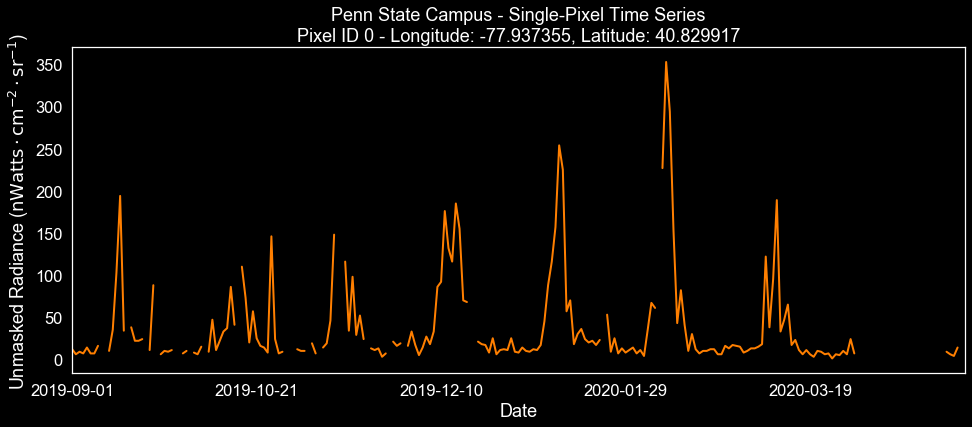

In [31]:
# Plot single-pixel time series
with plt.style.context('dark_background'):
    
    ax = pixel_id_0_radiance.plot(figsize=(16,6), grid=False, color='#ff7f00', linewidth=2)
    
    ax.set_title('Penn State Campus - Single-Pixel Time Series\nPixel ID 0 - Longitude: -77.937355, Latitude: 40.829917')
    ax.set_xlabel('Date')
    ax.set_ylabel('Unmasked Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)')

In [33]:
# # Note - Change date format (both now YYYY-MM-DD)
# #  makes the get cloud_mask_data() function not needed;
# #  both can use the get_radiance_data() function

# # Get Sept 2019 radiance value dataframes into list - FILLED
# sept_2019_radiance_filled = get_radiance_data(
#     psu_radiance_filled, year='2019', month='09')

# # Get Sept 2019 cloud mask dataframes into list - FILLED
# sept_2019_mask_filled = get_radiance_data(
#     psu_cloud_mask_filled, year='2019', month='09')

In [34]:
# sept_2019_radiance_filled[0].head()

In [35]:
# sept_2019_mask_filled[0].head()

In [36]:
# # Calculate mean radiance with filled data
# sept_2019_mean_radiance_filled = calculate_mean_radiance(
#     sept_2019_radiance_filled, sept_2019_mask_filled)

In [37]:
# # Confirm mean radiance (should be 611.1739)
# sept_2019_mean_radiance_filled.max()

### Create Plotting Extent

In [38]:
# Get min/max longitude and latitude values
lon_min = psu_lat_lon_df.Longitude.min()
lon_max = psu_lat_lon_df.Longitude.max()
lat_min = psu_lat_lon_df.Latitude.min()
lat_max = psu_lat_lon_df.Latitude.max()

In [39]:
# Display values
print(f"Lon min: {lon_min}\nLon max: {lon_max}\nLat min: {lat_min}\nLat max: {lat_max}")

Lon min: -77.93735504
Lon max: -77.77485504
Lat min: 40.75908399
Lat max: 40.82991733


In [40]:
# Get spacing for extent (assume lat/lon are centroids)
lon_spacing = (lon_max - lon_min) / 39
lat_spacing = (lat_max - lat_min) / 17

# Check to which decimal the lat and long spacings match
round(lon_spacing, 9) == round(lon_spacing, 9)

# Define single spacing
coord_spacing = round(lon_spacing, 9)

In [41]:
# Define extent
psu_extent = (
    lon_min - coord_spacing/2,
    lon_max + coord_spacing/2,
    lat_min - coord_spacing/2,
    lat_max + coord_spacing/2
)

In [42]:
# # Define extent
# psu_extent = (lon_min-0.004166999999995369/2, 
#               lon_max+0.004166999999995369/2, 
#               lat_min-0.004166999999995369/2, 
#               lat_max+0.004166999999995369/2)

In [43]:
# Show extent (xmin, xmax, ymin, ymax)
psu_extent

(-77.9394383735, -77.77277170650001, 40.7570006565, 40.832000663500004)

In [44]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [45]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

Store radiance data

 -- For each date in the date list, 
        finds the date in the dataframe based on column name, 
        creates a correctly formatted (shaped) array for that data (values and cloud mask)
        masks if necessary
        adds year/month/day index to dictionary as key and masked array as value

Workflow for storing data in dictionary:

* Define list of dates that for data that will be added to the dictionary
    * ```python
    date_list = get_date_list(
        start_date='2019-09-01', 
        end_date='2020-04-30')
    ```

* Store data in dictionary
    * ```python
    store_daily_radiance(
        filled_radiance_data, 
        filled_cloud_mask_data, 
        date_list)
    ```


* Get a d


Get daily data into a dictionary, for retrieval several different aggregation levels:

* Daily
* Monthly 
* Ranges of dates (in-between months)

Where data is centrally stored and many functions can act upon that data to run calculations.

1. Read data to dataframes

2. Add missing values

3. Create date list for looping through to pull radiance data (values and cloud mask)
    * *get_date_list()*
    

4. Store daily data in dictionary
    * *store_daily_radiance()*
    * ```python
    radiance_dict['Year']['Month']['Day']
    ```


5. Access values
    * Directly from dictionary for single days
    * Directly from dictionary for whole month data (to then average)
    * With the function *get_array_data_from_dict()* and input dictionary and date list for cross-month date list and/or specialized date list (weekly on Sundays, etc.) (offsets and/or anchored offsets)
        * https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
        
        
Should also do functions/workflow for individual pixel-based time series.

In [46]:
# Get list of dates (daily) from Sept 2019 to April 2020
date_list = get_date_list(start_date='2019-09-01', end_date='2020-04-30')

In [47]:
# Display number of days in list
len(date_list)

243

In [48]:
# Store all daily filled values in nested dictionary
#  (indexed by [Year][Month][Day])
radiance_sept_2019_apr_2020 = store_daily_radiance(
    psu_radiance_filled, psu_cloud_mask_filled, dates=date_list)

In [49]:
# Show top-level keys in dicionary (all years)
radiance_sept_2019_apr_2020.keys()

dict_keys(['2019', '2020'])

In [50]:
# Show keys for 2019 (all months)
radiance_sept_2019_apr_2020.get('2019').keys()

dict_keys(['09', '10', '11', '12'])

In [51]:
# Show keys for 2020(all months)
radiance_sept_2019_apr_2020.get('2020').keys()

dict_keys(['01', '02', '03', '04'])

In [58]:
# Get a month's worth of data (still in dictionary format)
march_2020_radiance_dict = radiance_sept_2019_apr_2020.get('2020').get('03')

In [59]:
# Show type of data
type(march_2020_radiance_dict)

dict

In [60]:
# Show March 2020 keys (all days) (includes masked and NaN values)
march_2020_radiance_dict.keys()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'])

In [61]:
# Get March 15, 2020 data (array)
march_15_2020_radiance = march_2020_radiance_dict.get('15')

In [63]:
# Show type
type(march_15_2020_radiance)

numpy.ma.core.MaskedArray

In [65]:
# # Display array
# march_15_2020_radiance

In [67]:
# Get March 01, 2020 data (array)
march_01_2020_radiance = march_2020_radiance_dict.get('01')

In [69]:
# # Display
# march_01_2020_radiance

In [326]:
march_2020 = test_dict.get('2020').get('03')

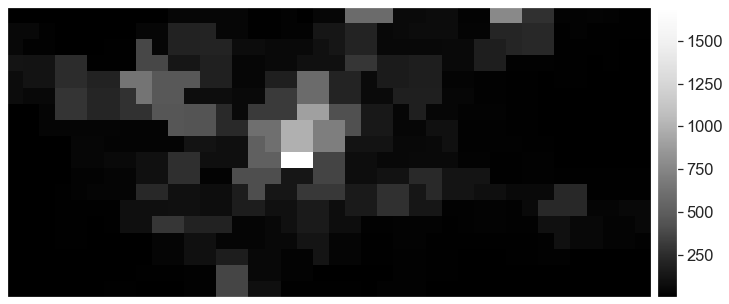

In [74]:
# Plot individual days worth of data for comparison
ep.plot_bands(march_01_2020_radiance, scale=False)

plt.show()

In [73]:
# Get min and max values for March 01
print(f"Min radiance: {march_01_2020_radiance.min()}")
print(f"Max radiance: {march_01_2020_radiance.max()}")

Min radiance: 4.0
Max radiance: 1697.0


In [87]:
# Get all March arrays as list
march_2020_array_list = [march_2020_radiance_dict.get(key) 
                         for key in march_2020_radiance_dict.keys()]

# Compute mean of a single month (provide list
#  of arrays to calculate_mean_radiance function)
march_2020_radiance_mean = calculate_mean_radiance(march_2020_array_list)

In [88]:
# Get min and max values for March 2020 mean
print(f"Min radiance: {march_2020_radiance_mean.min()}")
print(f"Max radiance: {march_2020_radiance_mean.max()}")

Min radiance: 21.741935483870968
Max radiance: 430.03225806451616


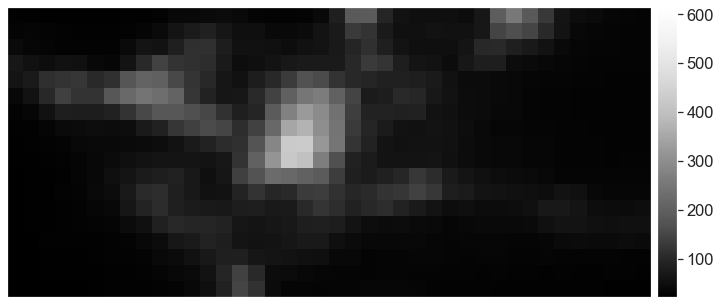

In [96]:
# Plot March 2020 mean
ep.plot_bands(march_2020_radiance_mean, scale=False, vmax=615)

In [90]:
# Get September 2019 values
september_2019_radiance_dict = radiance_sept_2019_apr_2020.get(
    '2019').get('09')

In [92]:
# Get all September arrays as list
sept_2019_array_list = [september_2019_radiance_dict.get(key) 
                         for key in september_2019_radiance_dict.keys()]

# Compute mean of a single month (provide list
#  of arrays to calculate_mean_radiance function)
sept_2019_radiance_mean = calculate_mean_radiance(sept_2019_array_list)

In [93]:
# Get min and max values for March 2020 mean
print(f"Min radiance: {sept_2019_radiance_mean.min()}")
print(f"Max radiance: {sept_2019_radiance_mean.max()}")

Min radiance: 21.565217391304348
Max radiance: 611.1739130434783


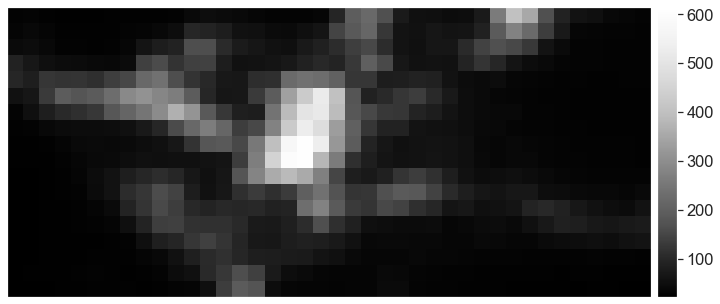

In [97]:
# Plot March 2020 mean
ep.plot_bands(sept_2019_radiance_mean, scale=False, vmax=615)

In [98]:
# Calculate difference from Sept 2019 to March 2020
diff_sept_2019_march_2020 = march_2020_radiance_mean - sept_2019_radiance_mean

In [105]:
# Get min and max values for difference in mean
print(f"Min difference (negative): {diff_sept_2019_march_2020.min()}")
print(f"Max difference (positive): {diff_sept_2019_march_2020.max()}")

Min difference (negative): -261.05469845722297
Max difference (positive): 28.802244039270676


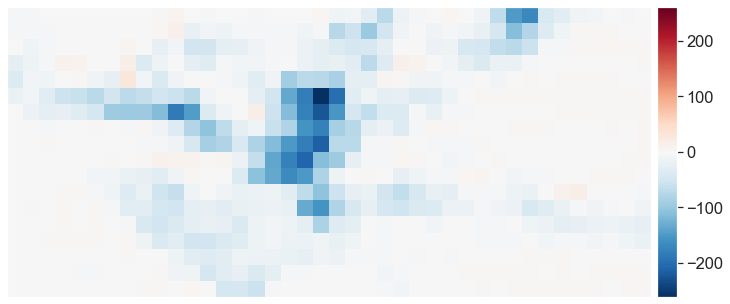

In [106]:
# Plot difference from Sept 2019 to March 2020
ep.plot_bands(
    diff_sept_2019_march_2020, 
    scale=False, 
    vmin=diff_sept_2019_march_2020.min(),
    vmax=-diff_sept_2019_march_2020.min(),
    cmap='RdBu_r')

plt.show()

### Full Month - Mean (Alternative Version)

In [131]:
# Get dates from Sept 01 - Sept 30
date_list = get_date_list('2019-09-01', '2019-09-30')

In [132]:
# Get array for each date into list
sept_01_sep_30_arrays = get_array_data_from_dict(
 dictionary=radiance_sept_2019_apr_2020, date_list=date_list)

In [133]:
# Confirm length
len(sept_01_sep_30_arrays)

30

In [134]:
# Calculate mean
sept_01_sep_30_mean = calculate_mean_radiance(sept_01_sep_30_arrays)

In [135]:
# Get min and max values for mean
print(f"Min: {sept_01_sep_30_mean.min()}")
print(f"Max: {sept_01_sep_30_mean.max()}")

Min: 21.565217391304348
Max: 611.1739130434783


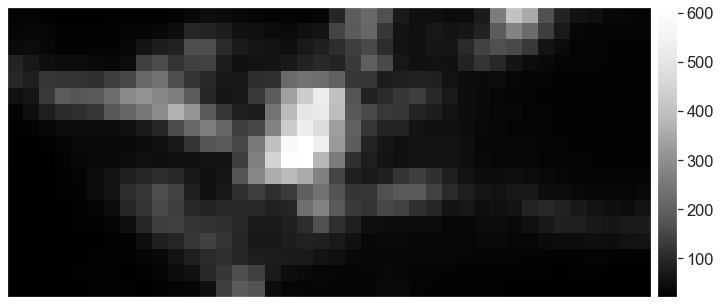

In [138]:
# Plot
ep.plot_bands(sept_01_sep_30_mean, scale=False, vmax=sept_01_sep_30_mean.max())

plt.show()

### Intra-Month Range - Mean

In [122]:
# Get dates from Sept 10 - Sept 20
date_list = get_date_list('2019-09-10', '2019-09-20')

In [123]:
# Get array for each date into list
sept_10_sep_20_arrays = get_array_data_from_dict(
 dictionary=radiance_sept_2019_apr_2020, date_list=date_list)

In [124]:
# Confirm length
len(sept_10_sep_20_arrays)

11

In [125]:
# Calculate mean
sept_10_sep_20_mean = calculate_mean_radiance(sept_10_sep_20_arrays)

In [126]:
# Get min and max values for mean
print(f"Min: {sept_10_sep_20_mean.min()}")
print(f"Max: {sept_10_sep_20_mean.max()}")

Min: 46.0
Max: 541.0


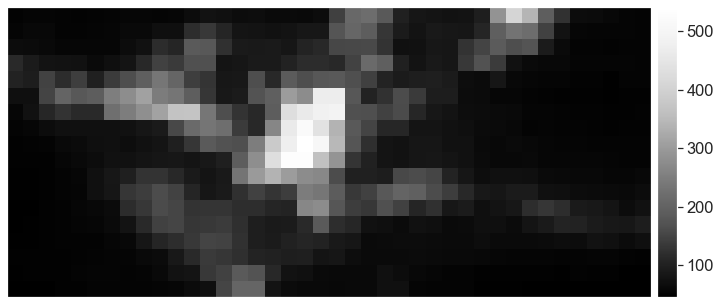

In [127]:
# Plot
ep.plot_bands(sept_10_sep_20_mean, scale=False, vmax=sept_10_sep_20_mean.max())

plt.show()

### Inter-Month Continuous Range - Mean

In [109]:
# Get dates from Sept 15 - Oct 15
date_list = get_date_list('2019-09-15', '2019-10-15')

In [115]:
# Get array for each date into list
sept_15_oct_15_arrays = get_array_data_from_dict(
 dictionary=radiance_sept_2019_apr_2020, date_list=date_list)

In [116]:
# Confirm length
len(sept_15_oct_15_arrays)

31

In [117]:
# Calculate mean
sept_15_oct_15_mean = calculate_mean_radiance(sept_15_oct_15_arrays)

In [118]:
# Get min and max values for mean
print(f"Min: {sept_15_oct_15_mean.min()}")
print(f"Max: {sept_15_oct_15_mean.max()}")

Min: 13.541666666666666
Max: 656.5833333333334


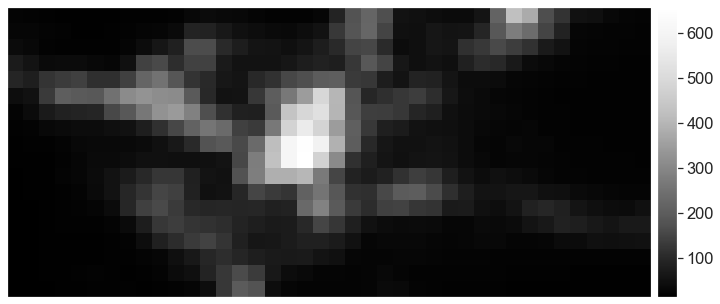

In [121]:
# Plot
ep.plot_bands(sept_15_oct_15_mean, scale=False, vmax=sept_15_oct_15_mean.max())

plt.show()

### Multiple Full Months - Mean

In [139]:
# Get dates from Dec 01 2019 - Jan 31 2020
date_list = get_date_list('2019-12-01', '2020-01-31')

In [141]:
# Get array for each date into list
dec_2019_jan_2020_arrays = get_array_data_from_dict(
 dictionary=radiance_sept_2019_apr_2020, date_list=date_list)

In [142]:
# Confirm length
len(dec_2019_jan_2020_arrays)

62

In [143]:
# Calculate mean
dec_2019_jan_2020_mean = calculate_mean_radiance(dec_2019_jan_2020_arrays)

In [144]:
# Get min and max values for mean
print(f"Min: {dec_2019_jan_2020_mean.min()}")
print(f"Max: {dec_2019_jan_2020_mean.max()}")

Min: 40.30508474576271
Max: 457.08474576271186


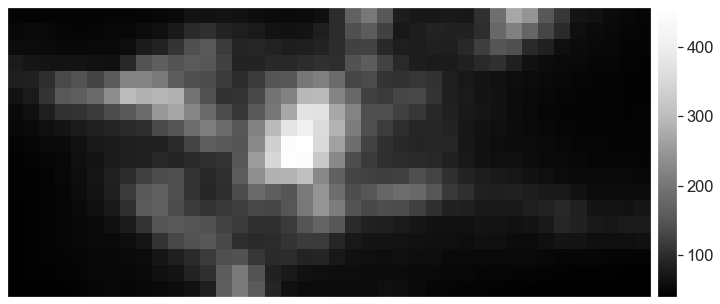

In [145]:
# Plot
ep.plot_bands(dec_2019_jan_2020_mean, scale=False, vmax=dec_2019_jan_2020_mean.max())

plt.show()

### Inter-Month (Every Specific Day) - Mean

Documentation for pandas *date_range*():

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets

Weekly:
* W-SUN - weekly frequency (Sundays). Same as ‘W’
* W-MON	- weekly frequency (Mondays)
* W-TUE - weekly frequency (Tuesdays)
* W-WED - weekly frequency (Wednesdays)
* W-THU - weekly frequency (Thursdays)
* W-FRI - weekly frequency (Fridays)
* W-SAT - weekly frequency (Saturdays)

#### Sundays

In [147]:
# Get Sundays from Sept 2019 - April 2020
date_list = get_date_list('2019-09-01', '2020-04-30', date_frequency='W-SUN')

In [149]:
# Get array for each date into list
sept_2019_apr_2020_sundays_arrays = get_array_data_from_dict(
 dictionary=radiance_sept_2019_apr_2020, date_list=date_list)

In [150]:
# Confirm length
len(sept_2019_apr_2020_sundays_arrays)

35

In [151]:
# Calculate mean
sept_2019_apr_2020_sundays_mean = calculate_mean_radiance(sept_2019_apr_2020_sundays_arrays)

In [152]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_sundays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_sundays_mean.max()}")

Min: 37.096774193548384
Max: 482.80645161290323


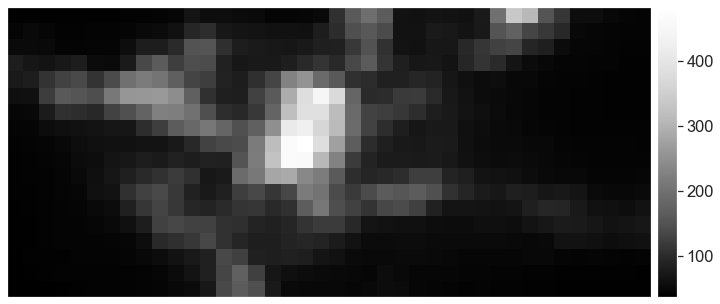

In [153]:
# Plot
ep.plot_bands(sept_2019_apr_2020_sundays_mean, scale=False,
              vmax=sept_2019_apr_2020_sundays_mean.max())

plt.show()

#### Mondays

In [176]:
# Get Mondays from Sept 2019 - April 2020
date_list = get_date_list('2019-09-01', '2020-04-30', date_frequency='W-MON')

In [177]:
# Get array for each date into list
sept_2019_apr_2020_mondays_arrays = get_array_data_from_dict(
 dictionary=radiance_sept_2019_apr_2020, date_list=date_list)

In [178]:
# Confirm length
len(sept_2019_apr_2020_mondays_arrays)

35

In [170]:
# Calculate mean
sept_2019_apr_2020_mondays_mean = calculate_mean_radiance(sept_2019_apr_2020_mondays_arrays)

In [171]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_mondays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_mondays_mean.max()}")

Min: 33.111111111111114
Max: 448.77777777777777


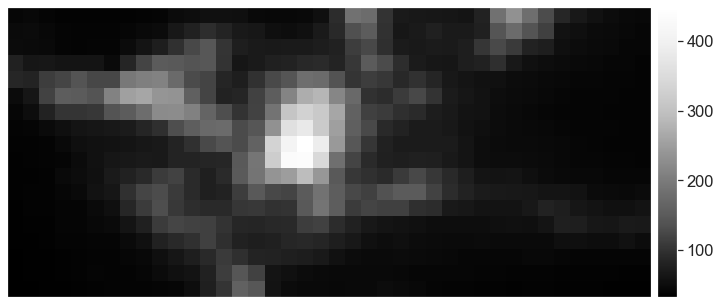

In [172]:
# Plot
ep.plot_bands(sept_2019_apr_2020_mondays_mean, scale=False,
              vmax=sept_2019_apr_2020_mondays_mean.max())

plt.show()

#### Business Days

In [179]:
# Get business days, March 2020
date_list = get_date_list('2020-03-01', '2020-03-14', date_frequency='B')

In [180]:
# Get array for each date into list
march_2020_business_arrays = get_array_data_from_dict(
 dictionary=radiance_sept_2019_apr_2020, date_list=date_list)

In [182]:
# Confirm length
len(march_2020_business_arrays)

10

In [183]:
# Calculate mean
march_2020_business_mean = calculate_mean_radiance(march_2020_business_arrays)

In [184]:
# Get min and max values for mean
print(f"Min: {march_2020_business_mean.min()}")
print(f"Max: {march_2020_business_mean.max()}")

Min: 42.8
Max: 592.9


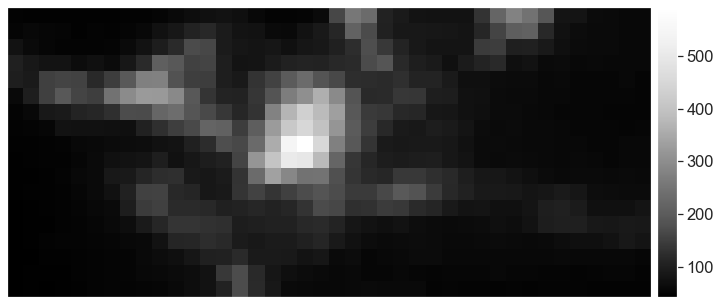

In [185]:
# Plot
ep.plot_bands(march_2020_business_mean, scale=False,
              vmax=march_2020_business_mean.max())

plt.show()

## Data Visualization

### Plot Cloud Free Mean Radiance Values for September 2019

In [ ]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot radiance values
ep.plot_bands(
    sept_2019_mean_radiance,
    title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax,
    vmax=sept_2019_mean_radiance.max())

# Plot lat/lon (centroids)
# psu_lat_lon_gdf.plot(ax=ax)

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        sept_2019_mean_radiance,
        hist_range=(0, sept_2019_mean_radiance.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (September 2019)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', 
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Mean Radiance Values for March 2020

In [ ]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(
    march_2020_mean_radiance,
    title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax, 
    vmax=sept_2019_mean_radiance.max())

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        march_2020_mean_radiance,
        hist_range=(0, sept_2019_mean_radiance.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (March 2020)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)',
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Change in Mean Radiance Values from September 2019 to March 2020

In [ ]:
# Plot change in radiance values
ep.plot_bands(
    radiance_diff_sept2019_march2020, 
    title="Difference in Mean Radiance (March 2020 - September 2019)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=radiance_diff_sept2019_march2020.min(),
    vmax=-radiance_diff_sept2019_march2020.min(),
    extent=psu_extent)

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        radiance_diff_sept2019_march2020,
        hist_range=(radiance_diff_sept2019_march2020.min(), -radiance_diff_sept2019_march2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

### Combined Plots

In [ ]:
# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        sept_2019_mean_radiance, title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_mean_radiance.max(),
        ax=ax[0],
        extent=psu_extent)

    ep.plot_bands(
        march_2020_mean_radiance, title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_mean_radiance.max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        radiance_diff_sept2019_march2020, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        cmap='RdBu_r',
        scale=False,
        vmin=radiance_diff_sept2019_march2020.min(),
        vmax=-radiance_diff_sept2019_march2020.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        radiance_diff_sept2019_march2020,
        #         bins=40,
        hist_range=(radiance_diff_sept2019_march2020.min(), -radiance_diff_sept2019_march2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

## Data Export

In [ ]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept2019.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march2020.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept2019-march2020.tif")

In [ ]:
# Define export transform
transform = from_origin(lon_min, lat_max, coord_spacing, coord_spacing)

# Define export metadata
psu_campus_metadata = {
    "driver": "GTiff",
    "dtype": radiance_diff_sept2019_march2020.dtype,
    "nodata": 0,
    "width": radiance_diff_sept2019_march2020.shape[1],
    "height": radiance_diff_sept2019_march2020.shape[0],
    "count": 1,
    "crs": psu_lat_lon_gdf.crs,  # +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
    "transform": transform
}

In [ ]:
# Export September 2019 radiance
export_to_geotiff(
    array=sept_2019_mean_radiance,
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
export_to_geotiff(
    array=march_2020_mean_radiance,
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
export_to_geotiff(
    array=radiance_diff_sept2019_march2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)